<a href="https://colab.research.google.com/github/tomonari-masada/course2021-nlp/blob/main/09_machine_translation_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNNによる機械翻訳
* encoder-decoder型のモデルを使う。
* 下記論文にある手法より少し凝ったものを実装する。
 * https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
 * 少し凝っているのは、encoderをbidirectionalにしているから。

![5346-sequence-to-sequence-learning-with-neural-networks_fig1.png](https://raw.githubusercontent.com/tomonari-masada/course-nlp2020/master/5346-sequence-to-sequence-learning-with-neural-networks_fig1.png)



* その他の参考資料

 * https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

* 部分的に、次のtutorialも参考にしている。
 * https://pytorch.org/tutorials/beginner/translation_transformer.html

## 手法の概要
* トークン列は、`<bos>`と`<eos>`という特殊なトークンで挟んで入力する。
 * それぞれ、文の始まりと終わりを意味するトークン。
* まず、エンコーダRNNを使って、入力シーケンスを隠れ状態へとエンコードする。
 * 隠れ状態は、あらかじめ定められた次元数をもつベクトル。
* この隠れ状態と、文の始まりを表す`<bos>`トークンとを、デコーダRNNへ入力する。
* そして、以下ひとつずつ、トークンを生成していく。

* RNN (Recurrent Neural Networks) については、下の記事がわかりやすい。
 * https://colah.github.io/posts/2015-08-Understanding-LSTMs/

 * 下の図での`<sos>`が今回のコードでの`<bos>`に対応する。

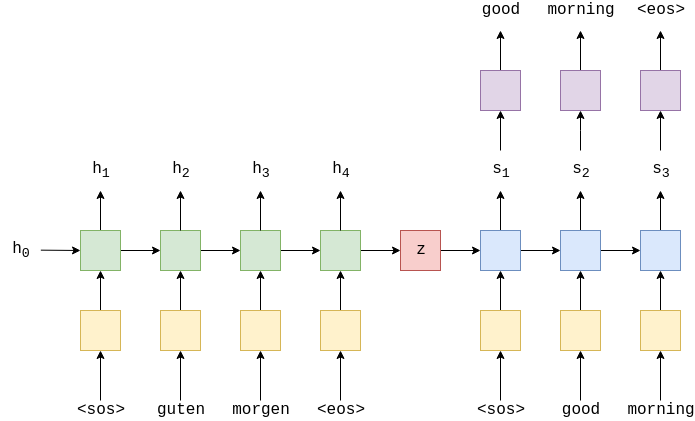

---

## 準備
* Google ColabのランタイムのタイプはGPUにしておく。

### spaCy関係の準備　

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [ ]:
import math
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(123)

### 両言語のトークナイザ
* `torchtext`を使う。
 * `torchtext`を使ったコードは、version 0.9より前とそれ以降とでかなり違うので、注意。

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holder
token_transform = {}

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

### トークンのリストを返すヘルパ関数

In [ ]:
def yield_tokens(data_iter, language):
  language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}
  for data_sample in data_iter:
    yield token_transform[language](data_sample[language_index[language]])

### 特殊なシンボルとそのインデックス
* インデックスとリスト内での順番が合っていることを確認する。

In [ ]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

## データセットの前処理
* 今回は、Multi30k Data Repositoryから、独英翻訳の部分を使う。 
 * https://github.com/multi30k/dataset
* データセットの取得には`torchtext.datasets`を利用している。

### 語彙集合
* まず、両言語の訓練データから、各言語のデータセットの語彙集合を作る。
 * 語彙集合の作成には、訓練データだけを使うこと!!


In [ ]:
# Place-holder 
vocab_transform = {}

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # 訓練データのイテレータ
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # torchtextのVocabオブジェクトを作る 
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                  min_freq=1,
                                                  specials=special_symbols,
                                                  special_first=True)

# UNK_IDXをデフォルトのインデックス（語彙集合に見つからなかった単語のインデックス）として設定する
# この作業をしておかないと実行時にエラーが出る
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

### Tokenization
* 両言語の文をトークン化してインデックスのリストにする。

In [ ]:
# 所定の変換用の関数を使ってトークン列を変換する関数を返す関数
def sequential_transforms(*transforms):
  def func(txt_input):
    for transform in transforms:
      txt_input = transform(txt_input)
    return txt_input
  return func

# BOS/EOSトークンを先頭/末尾に追加する関数
def tensor_transform(token_ids):
  return torch.cat((torch.tensor([BOS_IDX]),
                    torch.tensor(token_ids), 
                    torch.tensor([EOS_IDX])))

# 翻訳元と翻訳先のテキストをインデックスのリストへ変換する
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  text_transform[ln] = sequential_transforms(token_transform[ln], #トークナイゼーション
                                             vocab_transform[ln], #ベクトル列へ変換
                                             tensor_transform) #BOS/EOSを追加しテンソル化

## 訓練データ、検証データ、テストデータ

### Collationのための関数
* collationとは、バラバラのデータ（今回は文字列データ）を、ミニバッチへまとめあげる操作。

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# ばらばらの文字列サンプルをミニバッチへcollateする関数
# （DataLoaderのインスタンスを作るときにこの関数を指定する）
def collate_fn(batch):
  src_batch, tgt_batch = [], []
  for src_sample, tgt_sample in batch:
    src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
    tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
  tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
  return src_batch, tgt_batch

### DataLoader
* ミニバッチの形は[最長のトークン列の長さ, ミニバッチの大きさ]
 * 深層学習ではミニバッチの大きさが最初に来ることが多いが、NLPでは上のようにデータを準備することも多い。
 * 各トークン列は、最長のものと同じ長さになるまで、末尾にパディング用の特殊なトークンを追加される。

In [ ]:
from torchtext.data.functional import to_map_style_dataset

BATCH_SIZE = 100

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(to_map_style_dataset(train_iter), # こうしないとshuffle=Trueと設定できない
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_fn)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
print(batch[0].shape)
print(batch[1].shape)

In [ ]:
batch[0]

In [ ]:
print(vocab_transform['de'].lookup_tokens(list(batch[0].t()[0])))

* ミニバッチの個数

In [ ]:
len(train_dataloader)

* インスタンスの個数

In [ ]:
len(train_dataloader.dataset)

* 検証データとテストデータ

In [ ]:
valid_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
valid_dataloader = DataLoader(to_map_style_dataset(valid_iter), batch_size=BATCH_SIZE, collate_fn=collate_fn)

test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_dataloader = DataLoader(to_map_style_dataset(test_iter), batch_size=BATCH_SIZE, collate_fn=collate_fn)

* なぜ`shuffle=False`でよいのに、to_map_style_dataset()を適用するのか？

In [ ]:
# valid_iterのままでDataLoaderを作成してみる
valid_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
valid_dataloader = DataLoader(valid_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# 検証データを枚挙
for batch in valid_dataloader:
  print(batch[0].shape, batch[1].shape)

print('-' * 80)

# 続けて2回目の枚挙しようと思ってもできない！
for batch in valid_dataloader:
  print(batch[0].shape, batch[1].shape)

In [ ]:
# valid_iterにto_map_style_dataset()を適用してDataLoaderを作成する
valid_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
valid_dataloader = DataLoader(to_map_style_dataset(valid_iter), batch_size=BATCH_SIZE, collate_fn=collate_fn)

# 検証データを枚挙
for batch in valid_dataloader:
  print(batch[0].shape, batch[1].shape)

print('-' * 80)

# 何度でも枚挙できる
for _ in range(3):
  for batch in valid_dataloader:
    print(batch[0].shape, batch[1].shape)
  print('-' * 80)

## モデル
* エンコーダ
 * 入力として与えられたトークン列をまず埋め込み、そしてRNNによって隠れ状態を表すベクトルへと変換する。
 * 今回は、bidirectionalなRNNを使う。
* デコーダ
 * エンコーダRNNから受け取った隠れ状態ベクトルを受け取って、翻訳先の言語のトークン列を、RNNによって生成する。
 * デコーダは生成を行うため、bidirectionalにはできない。
* エンコーダ、デコーダ両方とも、LSTMではなく、GRUを使う。

seq2seq8.png

### エンコーダ
* インスタンスを作るときに指定する値の意味は以下の通り。
 * input_dim: 語彙サイズ
 * emb_dim: 単語埋め込みの次元数
 * enc_hid_dim: エンコーダの隠れ状態の次元数
 * dec_hid_dim: デコーダの隠れ状態の次元数
 * p: ドロップアウトの確率
* ここではLSTMではなくGRUを使う。しかも、双方向のGRUを使う。

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim,
               enc_hid_dim, dec_hid_dim, p=0.5):
    super().__init__()

    self.input_dim = input_dim
    self.emb_dim = emb_dim
    self.enc_hid_dim = enc_hid_dim
    self.dec_hid_dim = dec_hid_dim

    self.embedding = nn.Embedding(input_dim, emb_dim)
    self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
    self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
    self.dropout = nn.Dropout(p=p)

  def forward(self, src):
    # srcの形は(トークン列長, バッチサイズ)

    embedded = self.dropout(self.embedding(src))
    # embeddedの形は(トークン列長, バッチサイズ, 埋め込み次元数)

    outputs, hidden = self.rnn(embedded)
    # outputsの形は(トークン列長, バッチサイズ, 隠れ状態の次元数 * 2)
    # hiddenの形は(レイヤー数 * 2, バッチサイズ, 隠れ状態の次元数)
    #   hiddenは[forward_1, backward_1, forward_2, backward_2, ...]とスタックされている。

    hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
    # hiddenの型が(バッチサイズ, デコーダの隠れ状態の次元数)に変わる

    return outputs, hidden

### デコーダ
* やはり、LSTMではなく、GRUを使う。
* トークン列を生成できる必要があるため、bidirectionalなものは使えない。
* デコーダがエンコーダから受け取る情報として、エンコーダRNNの最後の隠れ状態を使うだけではあまりうまくいかない。
* そこで今回は、エンコーダRNNの隠れ状態だけでなく、エンコーダRNNの出力ベクトル列（入力トークン列に沿って得られるすべて隠れ状態）の平均も、デコーダの入力の一部として使う。
 * エンコーダRNNの出力ベクトル列を表すテンソルの形は[トークン列長, バッチサイズ, 隠れ状態の次元数*2]である。
 * これのトークン列長の方向に平均をとって、デコーダへの入力の一部として利用する。

In [ ]:
class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim,
               enc_hid_dim, dec_hid_dim, p=0.5):
    super().__init__()

    self.emb_dim = emb_dim
    self.enc_hid_dim = enc_hid_dim
    self.dec_hid_dim = dec_hid_dim
    self.output_dim = output_dim

    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
    self.out = nn.Linear(dec_hid_dim + (enc_hid_dim * 2) + emb_dim, output_dim)
    self.dropout = nn.Dropout(p=p)

  # デコーダのforwardメソッドは、1トークンずつ処理する
  def forward(self, input, decoder_hidden, mean_encoder_output):
    # inputの形は(バッチサイズ, )
    input = input.unsqueeze(0)
    #   こうすることで、inputの形は(1, バッチサイズ)になる
    embedded = self.dropout(self.embedding(input))
    # embeddedの形は(1, バッチサイズ, 埋め込み次元数)

    # mean_encoder_outputの型は(1, バッチサイズ, エンコーダ隠れ状態次元数 * 2)
    rnn_input = torch.cat((mean_encoder_output, embedded), dim=2)
    output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))
    embedded = embedded.squeeze(0)
    #   こうすることで、embeddedの形は(バッチサイズ, 埋め込み次元数)になる

    output = output.squeeze(0)
    #   こうすることで、outputの形は(バッチサイズ, デコーダ隠れ状態次元数)になる

    mean_encoder_output = mean_encoder_output.squeeze(0)
    #   こうすることで、mean_encoder_outputの形は(バッチサイズ, エンコーダ隠れ状態次元数 * 2)になる

    output = self.out(torch.cat((output, mean_encoder_output, embedded), dim=1))

    return output, decoder_hidden.squeeze(0)

### RNNの重みを初期化する関数
* 重みは標準偏差0.01の正規乱数で初期化。
* バイアスはゼロで初期化。

In [ ]:
def init_weights(m):
  for name, param in m.named_parameters():
    if 'weight' in name:
      nn.init.normal_(param.data, mean=0, std=0.01)
    else:
      nn.init.constant_(param.data, 0)

### エンコーダとデコーダをまとめて扱うためのクラス

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
       
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def forward(self, src, tgt, teacher_forcing_ratio=0.5, no_length_limit=False):
    # tgtの形は[トークン列長, バッチサイズ]
    max_len, batch_size = tgt.shape
    if no_length_limit:
      max_len *= 2
    tgt_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(max_len, batch_size, tgt_vocab_size).to(self.device)

    encoder_outputs, hidden = self.encoder(src)

    # デコーダへの最初の入力トークンは<bos>トークン
    # inputの形は(バッチサイズ, )
    input = tgt[0,:]

    # デコーダに1トークンずつ処理させるforループ
    for t in range(1, max_len):
      mean_encoder_output = encoder_outputs.mean(0, keepdim=True)
      output, hidden = self.decoder(input, hidden, mean_encoder_output)
      outputs[t] = output
      teacher_force = torch.rand(1).item() < teacher_forcing_ratio

      # 最大値を取る単語のインデックスを取得する
      top1 = output.max(1)[1]

      # teacher_forceがTrueならば、正解の単語のインデックスを使う
      # そうでなければ、モデルが確率最大と予測した単語のインデックスを使う
      input = (tgt[t] if teacher_force else top1)

    return outputs

### 定数

In [ ]:
INPUT_DIM = len(vocab_transform['de'])
OUTPUT_DIM = len(vocab_transform['en'])

ENC_EMB_DIM = 32
DEC_EMB_DIM = 32
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

### モデルのインスタンスの作成

In [ ]:
model = Seq2Seq(
    Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, p=ENC_DROPOUT),
    Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, p=DEC_DROPOUT),
    device
    ).to(device)

* モデルのパラメータ数を調べてみる。

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

### モデルの重みを初期化

In [ ]:
model.apply(init_weights)

### optimizer
* Adamをデフォルトの設定で使う。

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

### 損失関数

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

## 学習や評価のためのヘルパ関数の定義

### 訓練のための関数

In [ ]:
def train(model, loader, optimizer, criterion, clip):
  model.train()
  epoch_loss = 0
  
  for src, tgt in loader:
    src = src.to(device)
    tgt = tgt.to(device)

    output = model(src, tgt)
    output = output[1:].view(-1, output.shape[-1])
    tgt = tgt[1:].view(-1) # 範囲を[1:]とすることで<bos>トークンを除外

    loss = criterion(output, tgt)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

  return epoch_loss / len(loader)

### 評価のための関数

In [ ]:
def evaluate(model, loader, criterion):
  model.eval()
  epoch_loss = 0

  for src, tgt in loader:
    src = src.to(device)
    tgt = tgt.to(device)

    output = model(src, tgt, 0) # teacher forcingは無効にする
    output = output[1:].view(-1, output.shape[-1])
    tgt = tgt[1:].view(-1)

    loss = criterion(output, tgt)
    epoch_loss += loss.item()

  return epoch_loss / len(loader)

### 経過時間を表示する関数

In [ ]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

### チェックポイントの保存・読み込みの関数

In [ ]:
def save_checkpoint(path, model, optimizer, epoch):
  torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'epoch': epoch,
      }, path)
  
def load_checkpoint(path, model, optimizer):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return checkpoint['epoch']

## 学習の実行
* チェックポイントを保存するパスは各自設定してください。

In [ ]:
# 下記のパスは、あくまでも、例です。
LOAD_PATH = '/content/drive/MyDrive/2021Courses/NLP/09_NMT.tar' 
SAVE_PATH = '/content/drive/MyDrive/2021Courses/NLP/09_NMT.tar'

* チェックポイントのロード（エラーは無視）。

In [ ]:
init_epoch = 0
try:
  init_epoch = load_checkpoint(LOAD_PATH, model, optimizer)
except:
  print("Error!")
init_epoch += 1

* perplexityとは
 * perplexityは、値が小さいほど良い、という評価尺度。
 * perplexityは、実際に次の位置に来る単語についてモデルの予測した確率が、高ければ高いほど、良くなる。
 * この解説がわかりやすい→ https://www.slideshare.net/hoxo_m/perplexity
    * perplexityは、確率の逆数。（確率の逆数＝次に現れる単語の候補をどこまで狭く絞り込めているか）


In [ ]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(init_epoch, init_epoch + N_EPOCHS):

  start_time = time.time()
  train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
  valid_loss = evaluate(model, valid_dataloader, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if epoch % 10 == 0:
    save_checkpoint(SAVE_PATH, model, optimizer, epoch)

  print(f'Epoch: {epoch:3d}\t|\tTime: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f}\t|\tTrain PPL: {math.exp(train_loss):7.3f}')
  print(f'\tValid Loss: {valid_loss:.3f}\t|\tValid PPL: {math.exp(valid_loss):7.3f}')

## テストセット上で評価

### 定量的評価

In [ ]:
test_loss = evaluate(model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f}\t|\tTest PPL: {math.exp(test_loss):7.3f} |')

### 定性的評価(?)
* モデルによる翻訳を実際に確認してみる。

In [ ]:
#load_checkpoint(LOAD_PATH, model, optimizer)

In [ ]:
src, tgt = next(iter(test_dataloader))
src = src.to(device)
tgt = tgt.to(device)

outputs = model(src, tgt, 0, True)
for j in range(src.shape[1]):
  print('>', ' '.join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[1:, j]))))
  print('=', ' '.join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[1:, j]))))
  print('<', ' '.join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(outputs[1:, j, :].squeeze().argmax(1)))))
  print('-' * 64)